# Line plot

Comparison of sorting algorithms including **bubble sort**, **merge sort** and **built-in python sort**

In [1]:
import time
import random
import matplotlib.pyplot as plt

In [2]:
def benchmark(func):
    """This decorator replaces function output with it's computation time"""
    def function(*args, **kwargs):
        start = time.time()
        func(*args, **kwargs)
        return time.time() - start
    return function


@benchmark
def bubble_sort(array):
    n = len(array)
    for i in range(n):
        already_sorted = True
        for j in range(n - i - 1):
            if array[j] > array[j + 1]:
                array[j], array[j + 1] = array[j + 1], array[j]
                already_sorted = False
        if already_sorted:
            break
    return array


@benchmark
def merge_sort_wrap(array):
    """Wrap to avoid recursive function decoration"""
    # Nested function definitions are needed to avoid usage of global namespace
    def merge_sort(array):
        def merge(left, right):
            if len(left) == 0:
                return right
            if len(right) == 0:
                return left
            result = []
            index_left = index_right = 0
            while len(result) < len(left) + len(right):
                if left[index_left] <= right[index_right]:
                    result.append(left[index_left])
                    index_left += 1
                else:
                    result.append(right[index_right])
                    index_right += 1
                if index_right == len(right):
                    result += left[index_left:]
                    break
                if index_left == len(left):
                    result += right[index_right:]
                    break
            return result

        if len(array) < 2:
            return array
        midpoint = len(array) // 2
        return merge(left=merge_sort(array[:midpoint]), right=merge_sort(array[midpoint:]))
    return merge_sort(array)

sorted_bench = benchmark(sorted)

In [3]:
bubble_times = []
merge_times = []
builtin_times = []
for sequence_len in range(2, 3003, 50):
    sample_seq = [random.randint(0, 10e6) for _ in range(sequence_len)]
    
    bubble_times.append(bubble_sort(sample_seq))
    merge_times.append(merge_sort_wrap(sample_seq))
    builtin_times.append(sorted_bench(sample_seq))

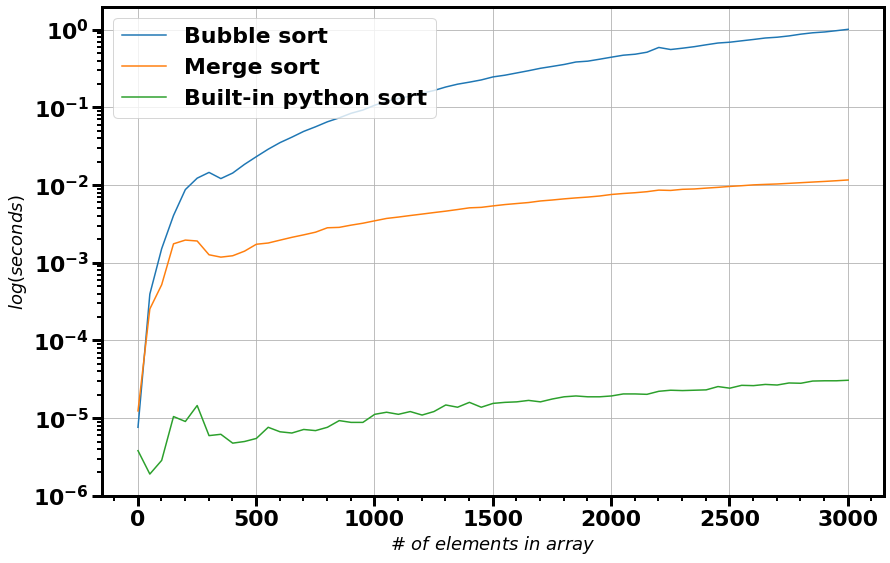

In [18]:
plt.rc("figure", figsize=(14, 9))
plt.plot(range(2, 3003, 50), bubble_times, label="Bubble sort")
plt.plot(range(2, 3003, 50), merge_times, label="Merge sort")
plt.plot(range(2, 3003, 50), builtin_times, label="Built-in python sort")
plt.xlabel("$\#\ of\ elements\ in\ array$", size=18)
plt.ylabel("$log(seconds)$", size=18)
plt.yscale("log")
plt.grid()
plt.legend(loc="upper left")

# Fasta sequence length distribution

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
def parse_fasta(filename):
    """
    Generator that yields fasta_id and sequence from fasta file.
    Bio.SeqIO.parse(...) from biopython may be used as an alternative
    """
    current_id = ""
    string = []
    with open(filename) as file_in:
        # Read lines from file until line is an empty string
        while line := file_in.readline().strip():
            if line.startswith(">"):
                if string:
                    yield current_id, "".join(string)
                    string = []
                current_id = line.lstrip(">")
            else:
                string.append(line)
        yield current_id, "".join(string)


filename = input("Enter path to fasta file: ")
sequence_lenghts = []
for _, sequence in parse_fasta(filename):
    sequence_lenghts.append(len(sequence))

plt.rc("figure", figsize=(17, 9))
sns.histplot(data=sequence_lenghts, kde=True, bins=len(sequence_lenghts)//40)
plt.xlabel("Sequence length")

Enter path to fasta file:  


FileNotFoundError: [Errno 2] No such file or directory: ''

# Volcano plot

Pre-processed RNAseq data on healthy tissue and tumor

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
data = pd.read_csv("data/volcano_data.csv", index_col=0)

In [27]:
# Subset 2 most up/down regulated genes
top_fc_down = data.query('logFC < 0 and pval_corr < 0.05').sort_values('logFC', ascending=True).head(2)
top_fc_up = data.query('logFC > 0 and pval_corr < 0.05').sort_values('logFC', ascending=False).head(2)
groups = {'Significantly downregulated': data.query('logFC < 0 and pval_corr < 0.05'),
          'Significantly upregulated': data.query('logFC > 0 and pval_corr < 0.05'),
          'Non-significantly downregulated': data.query('logFC < 0 and pval_corr > 0.05'),
          'Non-significantly upregulated': data.query('logFC > 0 and pval_corr > 0.05')}

In [28]:
# Define default plot parameters
plt.rc('figure', figsize=(25, 15))
plt.rc('font', size=22, weight='bold', style='normal')
plt.rc('xtick.minor', visible=True, size=5, width=2)
plt.rc('xtick.major', size=10, width=3)
plt.rc('ytick.minor', visible=True, size=5, width=2)
plt.rc('ytick.major', size=10, width=3)
plt.rc('axes', linewidth=3, labelsize=30, labelweight='bold', titlesize=48, titlepad=30, titleweight='bold')

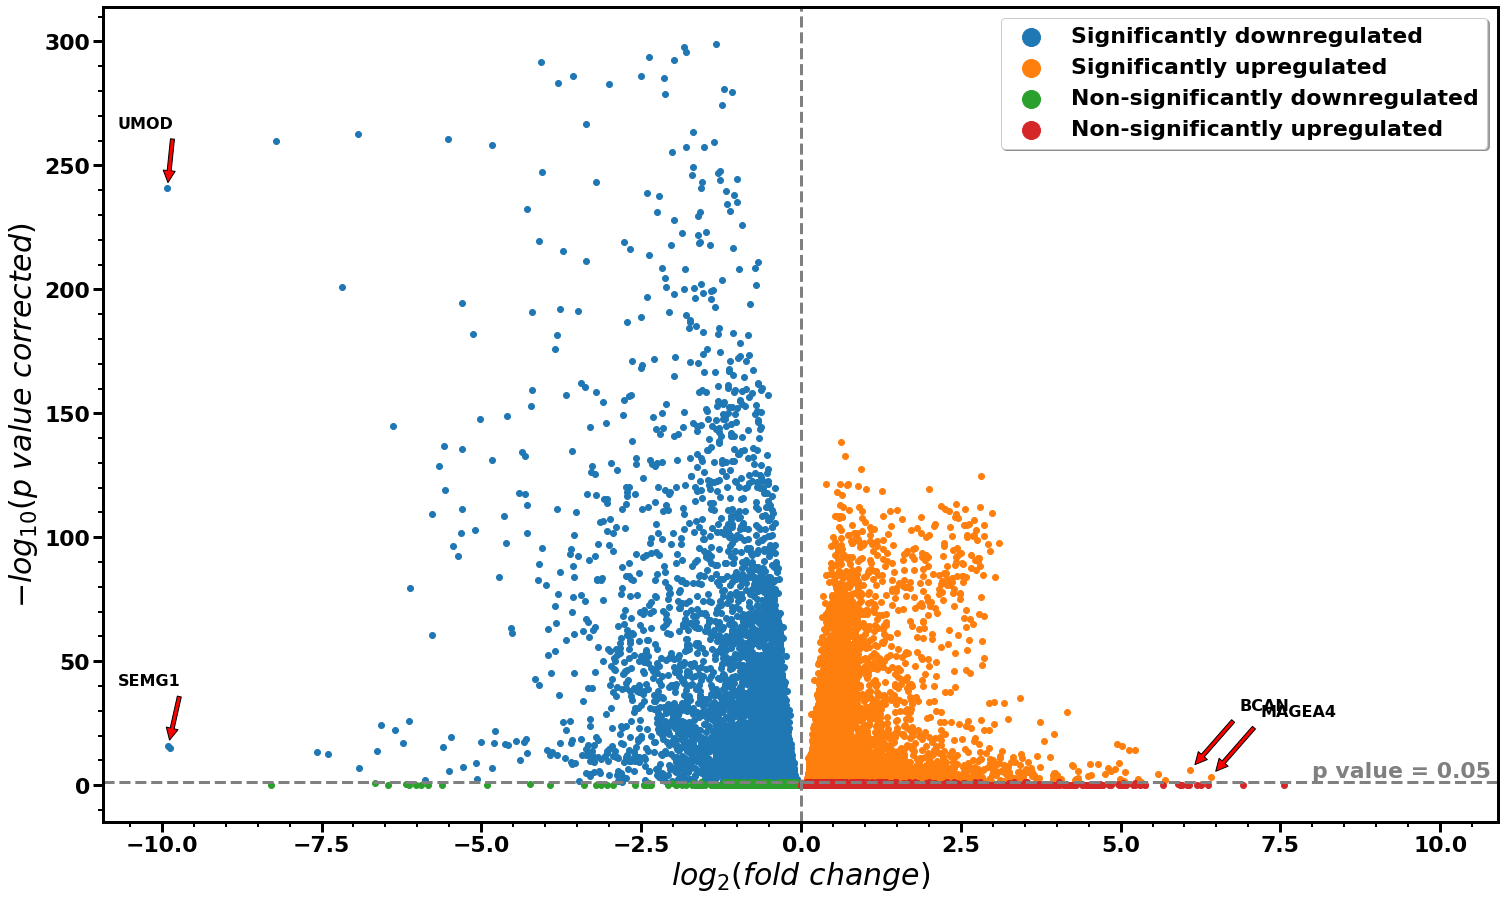

In [30]:
# Horizontal line (p_value = 0.05)
plt.axhline(-np.log10(0.05), linestyle='--', color='gray', linewidth=3)
# Vertical line (logFC = 0)
plt.axvline(0, linestyle='--', color='gray', linewidth=3)
# Horizontal line annotation (best position is hardcoded)
plt.text(8, -np.log10(0.001), 'p value = 0.05', color='gray')

# Each group is drawn separately
for group, dat in groups.items():  
    plt.scatter('logFC', 'log_pval', data=dat, label=group)

# Annotation of top downregulated genes
for gene, values in top_fc_down.iterrows():
    plt.annotate(xy=(values['logFC'], values['log_pval']),        # Point position (x, y)
                 xytext=(-50, 60), text=gene,                     # Point offset (x, y) and text
                 textcoords='offset points', fontsize=16,         # Offset type and font size
                 arrowprops=dict(width=4.0, facecolor='red',      # Arrow parameters: width, color, edgecolor
                                 edgecolor='k', shrink=0.1))      # "Shrink" is something like width/length

# Annotation of top upregulated genes
for gene, values in top_fc_up.iterrows():
    plt.annotate(xy=(values['logFC'], values['log_pval']),
                 xytext=(50, 60), text=gene,
                 textcoords='offset points', fontsize=16,
                 arrowprops=dict(width=4.0, facecolor='red',
                                 edgecolor='k', shrink=0.1))
    
plt.xlabel('$log_2(fold\ change)$')
plt.ylabel('$-log_{10}(p\ value\ corrected)$')
# Limit x axis for better view
plt.gca().set_xlim([-max(abs(data['logFC']))-1, max(abs(data['logFC']))+1])
plt.legend(markerscale=3, shadow=True)